In [1]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr

In [2]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, _ in user_ratings[:n]]

    return top_n

In [3]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

train_df, test_df = train_test_split(data_df, test_size=0.2)
U = sorted(train_df["user_id"].unique())

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_df.to_records(index=False)]
raw_testset = [(ruid, riid, r, None) for ruid, riid, r in test_df.to_records(index=False)]
trainset = Dataset.construct_trainset(dataset, raw_trainset)
testset = Dataset.construct_testset(dataset, raw_testset)

# KNN similarity, popularity

In [4]:
BEST_K = 7

In [5]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim, precomputed_pop=pop, tau_2=0.5)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [6]:
maes = np.zeros(train_df["user_id"].nunique())
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim, precomputed_pop=pop, tau_2=0.5)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    mae_without_u = accuracy.mae(predictions_without_u, verbose=False)
    maes[ruid] = mae_without_u
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f, MAE Diff: %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid], maes[ruid] - mae))
    
    i += 1

[0.106045% Done] Time elapsed 0:00:05.689428, Influence 0.273166, MAE Diff: 0.041613
[0.212089% Done] Time elapsed 0:00:11.072899, Influence 0.273176, MAE Diff: 0.041002
[0.318134% Done] Time elapsed 0:00:16.396446, Influence 0.273546, MAE Diff: 0.040779
[0.424178% Done] Time elapsed 0:00:21.857630, Influence 0.272664, MAE Diff: 0.037878
[0.530223% Done] Time elapsed 0:00:27.377458, Influence 0.273834, MAE Diff: 0.037930
[0.636267% Done] Time elapsed 0:00:33.328587, Influence 0.274218, MAE Diff: 0.037920
[0.742312% Done] Time elapsed 0:00:39.210747, Influence 0.274662, MAE Diff: 0.037888
[0.848356% Done] Time elapsed 0:00:44.651481, Influence 0.273877, MAE Diff: 0.038079
[0.954401% Done] Time elapsed 0:00:50.336890, Influence 0.273480, MAE Diff: 0.038395
[1.060445% Done] Time elapsed 0:00:55.857498, Influence 0.272860, MAE Diff: 0.039336
[1.166490% Done] Time elapsed 0:01:01.662630, Influence 0.273685, MAE Diff: 0.038748
[1.272534% Done] Time elapsed 0:01:07.050622, Influence 0.272736,

[10.392365% Done] Time elapsed 0:09:15.369820, Influence 0.262688, MAE Diff: 0.030693
[10.498409% Done] Time elapsed 0:09:21.099766, Influence 0.262250, MAE Diff: 0.029475
[10.604454% Done] Time elapsed 0:09:26.742784, Influence 0.261630, MAE Diff: 0.029789
[10.710498% Done] Time elapsed 0:09:32.321331, Influence 0.261523, MAE Diff: 0.029561
[10.816543% Done] Time elapsed 0:09:38.081592, Influence 0.261305, MAE Diff: 0.029601
[10.922587% Done] Time elapsed 0:09:44.100536, Influence 0.261659, MAE Diff: 0.029710
[11.028632% Done] Time elapsed 0:09:50.726620, Influence 0.261305, MAE Diff: 0.029698
[11.134677% Done] Time elapsed 0:09:56.985893, Influence 0.261422, MAE Diff: 0.029647
[11.240721% Done] Time elapsed 0:10:02.483310, Influence 0.261646, MAE Diff: 0.029390
[11.346766% Done] Time elapsed 0:10:07.837205, Influence 0.260977, MAE Diff: 0.029751
[11.452810% Done] Time elapsed 0:10:13.218552, Influence 0.261323, MAE Diff: 0.029688
[11.558855% Done] Time elapsed 0:10:18.533989, Influen

[20.572641% Done] Time elapsed 0:17:49.141049, Influence 0.240919, MAE Diff: 0.023321
[20.678685% Done] Time elapsed 0:17:54.170643, Influence 0.240751, MAE Diff: 0.021779
[20.784730% Done] Time elapsed 0:17:59.131686, Influence 0.240704, MAE Diff: 0.021795
[20.890774% Done] Time elapsed 0:18:04.265597, Influence 0.240913, MAE Diff: 0.022181
[20.996819% Done] Time elapsed 0:18:09.231432, Influence 0.240782, MAE Diff: 0.021808
[21.102863% Done] Time elapsed 0:18:14.293121, Influence 0.240031, MAE Diff: 0.021650
[21.208908% Done] Time elapsed 0:18:19.274253, Influence 0.240080, MAE Diff: 0.021749
[21.314952% Done] Time elapsed 0:18:24.232223, Influence 0.240071, MAE Diff: 0.021882
[21.420997% Done] Time elapsed 0:18:29.223129, Influence 0.239468, MAE Diff: 0.021914
[21.527041% Done] Time elapsed 0:18:34.151250, Influence 0.240071, MAE Diff: 0.022071
[21.633086% Done] Time elapsed 0:18:39.126260, Influence 0.239682, MAE Diff: 0.022105
[21.739130% Done] Time elapsed 0:18:44.073158, Influen

[30.752916% Done] Time elapsed 0:26:16.267173, Influence 0.214502, MAE Diff: 0.017148
[30.858961% Done] Time elapsed 0:26:21.295348, Influence 0.214191, MAE Diff: 0.017908
[30.965005% Done] Time elapsed 0:26:26.356090, Influence 0.213768, MAE Diff: 0.017569
[31.071050% Done] Time elapsed 0:26:31.430854, Influence 0.213944, MAE Diff: 0.018200
[31.177094% Done] Time elapsed 0:26:36.362554, Influence 0.213561, MAE Diff: 0.017807
[31.283139% Done] Time elapsed 0:26:41.358734, Influence 0.213203, MAE Diff: 0.017713
[31.389183% Done] Time elapsed 0:26:46.375156, Influence 0.210415, MAE Diff: 0.016974
[31.495228% Done] Time elapsed 0:26:51.404527, Influence 0.210415, MAE Diff: 0.017221
[31.601273% Done] Time elapsed 0:26:56.343667, Influence 0.210869, MAE Diff: 0.017435
[31.707317% Done] Time elapsed 0:27:01.444507, Influence 0.210608, MAE Diff: 0.017319
[31.813362% Done] Time elapsed 0:27:06.340695, Influence 0.211051, MAE Diff: 0.017078
[31.919406% Done] Time elapsed 0:27:11.352711, Influen

[40.933192% Done] Time elapsed 0:34:16.667338, Influence 0.173074, MAE Diff: 0.013777
[41.039236% Done] Time elapsed 0:34:21.560156, Influence 0.172260, MAE Diff: 0.013805
[41.145281% Done] Time elapsed 0:34:26.666563, Influence 0.172260, MAE Diff: 0.013924
[41.251326% Done] Time elapsed 0:34:31.580256, Influence 0.172714, MAE Diff: 0.013822
[41.357370% Done] Time elapsed 0:34:36.524934, Influence 0.171956, MAE Diff: 0.013649
[41.463415% Done] Time elapsed 0:34:41.467976, Influence 0.171681, MAE Diff: 0.013094
[41.569459% Done] Time elapsed 0:34:46.479825, Influence 0.171598, MAE Diff: 0.013343
[41.675504% Done] Time elapsed 0:34:51.515335, Influence 0.171125, MAE Diff: 0.012804
[41.781548% Done] Time elapsed 0:34:56.478623, Influence 0.171392, MAE Diff: 0.012922
[41.887593% Done] Time elapsed 0:35:01.519518, Influence 0.170994, MAE Diff: 0.012622
[41.993637% Done] Time elapsed 0:35:06.604758, Influence 0.159137, MAE Diff: 0.012191
[42.099682% Done] Time elapsed 0:35:11.666133, Influen

[51.113468% Done] Time elapsed 0:42:20.239461, Influence 0.108028, MAE Diff: 0.009028
[51.219512% Done] Time elapsed 0:42:25.259934, Influence 0.108028, MAE Diff: 0.009020
[51.325557% Done] Time elapsed 0:42:30.188583, Influence 0.108028, MAE Diff: 0.009024
[51.431601% Done] Time elapsed 0:42:35.189427, Influence 0.108028, MAE Diff: 0.009088
[51.537646% Done] Time elapsed 0:42:40.081838, Influence 0.108412, MAE Diff: 0.009063
[51.643690% Done] Time elapsed 0:42:45.097066, Influence 0.107927, MAE Diff: 0.009239
[51.749735% Done] Time elapsed 0:42:50.021153, Influence 0.107983, MAE Diff: 0.008867
[51.855779% Done] Time elapsed 0:42:54.950285, Influence 0.107686, MAE Diff: 0.008873
[51.961824% Done] Time elapsed 0:42:59.914232, Influence 0.107686, MAE Diff: 0.008863
[52.067869% Done] Time elapsed 0:43:04.950476, Influence 0.107686, MAE Diff: 0.008790
[52.173913% Done] Time elapsed 0:43:09.873117, Influence 0.108100, MAE Diff: 0.008819
[52.279958% Done] Time elapsed 0:43:14.707158, Influen

[61.293743% Done] Time elapsed 0:50:18.025887, Influence 0.079099, MAE Diff: 0.005652
[61.399788% Done] Time elapsed 0:50:22.991911, Influence 0.078492, MAE Diff: 0.006066
[61.505832% Done] Time elapsed 0:50:28.073338, Influence 0.078628, MAE Diff: 0.005730
[61.611877% Done] Time elapsed 0:50:33.207334, Influence 0.078523, MAE Diff: 0.005774
[61.717922% Done] Time elapsed 0:50:38.197622, Influence 0.077102, MAE Diff: 0.005783
[61.823966% Done] Time elapsed 0:50:43.053342, Influence 0.077102, MAE Diff: 0.005579
[61.930011% Done] Time elapsed 0:50:48.031970, Influence 0.077354, MAE Diff: 0.005428
[62.036055% Done] Time elapsed 0:50:52.898132, Influence 0.076748, MAE Diff: 0.005356
[62.142100% Done] Time elapsed 0:50:57.964601, Influence 0.076748, MAE Diff: 0.005475
[62.248144% Done] Time elapsed 0:51:02.991434, Influence 0.076909, MAE Diff: 0.005350
[62.354189% Done] Time elapsed 0:51:07.903965, Influence 0.076968, MAE Diff: 0.005317
[62.460233% Done] Time elapsed 0:51:12.853918, Influen

[71.474019% Done] Time elapsed 0:58:47.794713, Influence 0.039995, MAE Diff: 0.002465
[71.580064% Done] Time elapsed 0:58:53.192994, Influence 0.039120, MAE Diff: 0.002374
[71.686108% Done] Time elapsed 0:58:58.613709, Influence 0.039120, MAE Diff: 0.002444
[71.792153% Done] Time elapsed 0:59:04.010961, Influence 0.038766, MAE Diff: 0.002350
[71.898197% Done] Time elapsed 0:59:09.227779, Influence 0.038766, MAE Diff: 0.002342
[72.004242% Done] Time elapsed 0:59:14.386099, Influence 0.038766, MAE Diff: 0.002361
[72.110286% Done] Time elapsed 0:59:19.494856, Influence 0.038766, MAE Diff: 0.002263
[72.216331% Done] Time elapsed 0:59:24.642934, Influence 0.038855, MAE Diff: 0.002278
[72.322375% Done] Time elapsed 0:59:29.862481, Influence 0.038928, MAE Diff: 0.002616
[72.428420% Done] Time elapsed 0:59:35.065138, Influence 0.032976, MAE Diff: 0.002106
[72.534464% Done] Time elapsed 0:59:40.353877, Influence 0.033273, MAE Diff: 0.002369
[72.640509% Done] Time elapsed 0:59:45.731013, Influen

[81.654295% Done] Time elapsed 1:07:24.244442, Influence 0.013174, MAE Diff: 0.001356
[81.760339% Done] Time elapsed 1:07:29.746085, Influence 0.013073, MAE Diff: 0.001444
[81.866384% Done] Time elapsed 1:07:35.250449, Influence 0.012466, MAE Diff: 0.001185
[81.972428% Done] Time elapsed 1:07:40.899088, Influence 0.009728, MAE Diff: 0.001166
[82.078473% Done] Time elapsed 1:07:46.609226, Influence 0.010170, MAE Diff: 0.000941
[82.184517% Done] Time elapsed 1:07:52.294552, Influence 0.009567, MAE Diff: 0.001105
[82.290562% Done] Time elapsed 1:07:58.139153, Influence 0.009966, MAE Diff: 0.000800
[82.396607% Done] Time elapsed 1:08:03.782382, Influence 0.008768, MAE Diff: 0.000653
[82.502651% Done] Time elapsed 1:08:09.750191, Influence 0.008768, MAE Diff: 0.000720
[82.608696% Done] Time elapsed 1:08:15.197737, Influence 0.008768, MAE Diff: 0.000679
[82.714740% Done] Time elapsed 1:08:20.478239, Influence 0.008896, MAE Diff: 0.000656
[82.820785% Done] Time elapsed 1:08:26.095283, Influen

[91.728526% Done] Time elapsed 1:15:52.904066, Influence 0.003256, MAE Diff: -0.000140
[91.834571% Done] Time elapsed 1:15:57.831007, Influence 0.003256, MAE Diff: -0.000071
[91.940615% Done] Time elapsed 1:16:02.801523, Influence 0.003256, MAE Diff: -0.000160
[92.046660% Done] Time elapsed 1:16:07.663996, Influence 0.003256, MAE Diff: -0.000149
[92.152704% Done] Time elapsed 1:16:12.653241, Influence 0.003063, MAE Diff: -0.000148
[92.258749% Done] Time elapsed 1:16:17.533131, Influence 0.003063, MAE Diff: 0.000052
[92.364793% Done] Time elapsed 1:16:22.462244, Influence 0.003063, MAE Diff: 0.000005
[92.470838% Done] Time elapsed 1:16:27.539297, Influence 0.003281, MAE Diff: 0.000203
[92.576882% Done] Time elapsed 1:16:32.466988, Influence 0.002633, MAE Diff: -0.000131
[92.682927% Done] Time elapsed 1:16:37.432490, Influence 0.002027, MAE Diff: -0.000036
[92.788971% Done] Time elapsed 1:16:42.360808, Influence 0.002027, MAE Diff: -0.000056
[92.895016% Done] Time elapsed 1:16:47.345168,

Text(0.5, 1.0, 'Spearman Rank Correlation 0.0126 (p-value: 0.7003)')

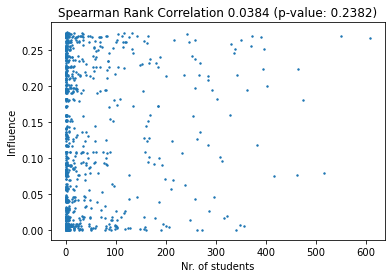

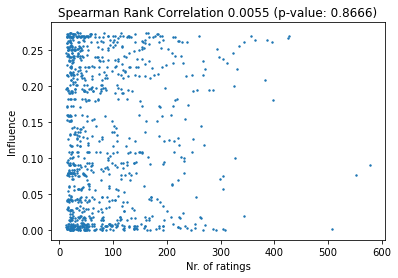

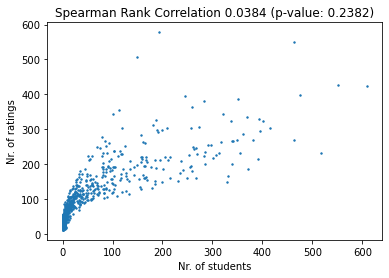

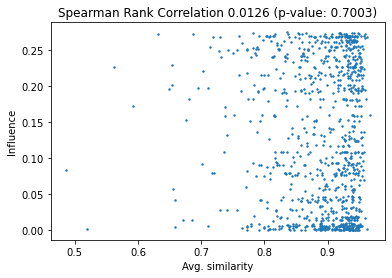

In [7]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.4f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.4f)" % (r, p))

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.4f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.4f)" % (r, p))

In [8]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.1845, All mentors: 0.1290
[Avg. Degree] Highest influential mentors: 31.3000, All mentors: 42.5673


# KNN similarity, popularity, reuse

In [9]:
BEST_K = 7

In [10]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim, precomputed_pop=pop, tau_2=0.5, reuse=True)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [11]:
maes = np.zeros(train_df["user_id"].nunique())
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim, precomputed_pop=pop, tau_2=0.5, reuse=True)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    mae_without_u = accuracy.mae(predictions_without_u, verbose=False)
    maes[ruid] = mae_without_u
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f, MAE Diff: %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid], maes[ruid] - mae))
    
    i += 1

[0.106045% Done] Time elapsed 0:00:04.525243, Influence 0.274832, MAE Diff: 0.039954
[0.212089% Done] Time elapsed 0:00:09.178184, Influence 0.274512, MAE Diff: 0.039616
[0.318134% Done] Time elapsed 0:00:13.653813, Influence 0.275089, MAE Diff: 0.039759
[0.424178% Done] Time elapsed 0:00:18.025051, Influence 0.274135, MAE Diff: 0.036516
[0.530223% Done] Time elapsed 0:00:22.503280, Influence 0.274353, MAE Diff: 0.035797
[0.636267% Done] Time elapsed 0:00:26.986225, Influence 0.274737, MAE Diff: 0.035901
[0.742312% Done] Time elapsed 0:00:31.376920, Influence 0.275124, MAE Diff: 0.035558
[0.848356% Done] Time elapsed 0:00:35.665240, Influence 0.274717, MAE Diff: 0.035506
[0.954401% Done] Time elapsed 0:00:39.997322, Influence 0.274033, MAE Diff: 0.035908
[1.060445% Done] Time elapsed 0:00:44.649193, Influence 0.274263, MAE Diff: 0.036401
[1.166490% Done] Time elapsed 0:00:49.258821, Influence 0.272317, MAE Diff: 0.034958
[1.272534% Done] Time elapsed 0:00:53.752340, Influence 0.269682,

[10.392365% Done] Time elapsed 0:07:41.605767, Influence 0.259483, MAE Diff: 0.030662
[10.498409% Done] Time elapsed 0:07:45.970028, Influence 0.260495, MAE Diff: 0.029196
[10.604454% Done] Time elapsed 0:07:50.284574, Influence 0.259819, MAE Diff: 0.029703
[10.710498% Done] Time elapsed 0:07:54.598242, Influence 0.259494, MAE Diff: 0.028767
[10.816543% Done] Time elapsed 0:07:58.915894, Influence 0.259276, MAE Diff: 0.028961
[10.922587% Done] Time elapsed 0:08:03.183310, Influence 0.259630, MAE Diff: 0.029000
[11.028632% Done] Time elapsed 0:08:07.503582, Influence 0.259276, MAE Diff: 0.028930
[11.134677% Done] Time elapsed 0:08:11.845410, Influence 0.259690, MAE Diff: 0.028831
[11.240721% Done] Time elapsed 0:08:16.268450, Influence 0.259773, MAE Diff: 0.028669
[11.346766% Done] Time elapsed 0:08:20.563549, Influence 0.259076, MAE Diff: 0.028784
[11.452810% Done] Time elapsed 0:08:25.196749, Influence 0.259772, MAE Diff: 0.028891
[11.558855% Done] Time elapsed 0:08:29.999792, Influen

[20.572641% Done] Time elapsed 0:14:57.503536, Influence 0.243083, MAE Diff: 0.021326
[20.678685% Done] Time elapsed 0:15:01.856407, Influence 0.240350, MAE Diff: 0.020680
[20.784730% Done] Time elapsed 0:15:06.269612, Influence 0.239742, MAE Diff: 0.020731
[20.890774% Done] Time elapsed 0:15:10.673751, Influence 0.240142, MAE Diff: 0.021207
[20.996819% Done] Time elapsed 0:15:14.940320, Influence 0.239757, MAE Diff: 0.020773
[21.102863% Done] Time elapsed 0:15:19.253613, Influence 0.239471, MAE Diff: 0.020784
[21.208908% Done] Time elapsed 0:15:23.725193, Influence 0.239347, MAE Diff: 0.021098
[21.314952% Done] Time elapsed 0:15:28.439240, Influence 0.240434, MAE Diff: 0.021133
[21.420997% Done] Time elapsed 0:15:32.928369, Influence 0.239714, MAE Diff: 0.021165
[21.527041% Done] Time elapsed 0:15:37.613556, Influence 0.240204, MAE Diff: 0.021217
[21.633086% Done] Time elapsed 0:15:41.993850, Influence 0.240141, MAE Diff: 0.021548
[21.739130% Done] Time elapsed 0:15:46.453868, Influen

[30.752916% Done] Time elapsed 0:21:55.997475, Influence 0.213465, MAE Diff: 0.016522
[30.858961% Done] Time elapsed 0:22:00.285504, Influence 0.214695, MAE Diff: 0.017402
[30.965005% Done] Time elapsed 0:22:04.564604, Influence 0.214389, MAE Diff: 0.016920
[31.071050% Done] Time elapsed 0:22:08.905387, Influence 0.214491, MAE Diff: 0.017575
[31.177094% Done] Time elapsed 0:22:13.171031, Influence 0.214656, MAE Diff: 0.017119
[31.283139% Done] Time elapsed 0:22:17.437097, Influence 0.215379, MAE Diff: 0.016533
[31.389183% Done] Time elapsed 0:22:21.858569, Influence 0.213351, MAE Diff: 0.015874
[31.495228% Done] Time elapsed 0:22:26.237122, Influence 0.213351, MAE Diff: 0.016136
[31.601273% Done] Time elapsed 0:22:30.640548, Influence 0.213871, MAE Diff: 0.016397
[31.707317% Done] Time elapsed 0:22:34.950072, Influence 0.214130, MAE Diff: 0.016404
[31.813362% Done] Time elapsed 0:22:39.284123, Influence 0.214317, MAE Diff: 0.016263
[31.919406% Done] Time elapsed 0:22:43.558977, Influen

[40.933192% Done] Time elapsed 0:29:15.589719, Influence 0.186929, MAE Diff: 0.010516
[41.039236% Done] Time elapsed 0:29:20.150878, Influence 0.186063, MAE Diff: 0.010482
[41.145281% Done] Time elapsed 0:29:24.712928, Influence 0.186063, MAE Diff: 0.010602
[41.251326% Done] Time elapsed 0:29:29.259181, Influence 0.185559, MAE Diff: 0.010343
[41.357370% Done] Time elapsed 0:29:33.771377, Influence 0.185700, MAE Diff: 0.009990
[41.463415% Done] Time elapsed 0:29:38.527642, Influence 0.185871, MAE Diff: 0.009512
[41.569459% Done] Time elapsed 0:29:43.485092, Influence 0.185595, MAE Diff: 0.009768
[41.675504% Done] Time elapsed 0:29:48.235049, Influence 0.184806, MAE Diff: 0.009082
[41.781548% Done] Time elapsed 0:29:52.733031, Influence 0.184938, MAE Diff: 0.009276
[41.887593% Done] Time elapsed 0:29:57.334217, Influence 0.182878, MAE Diff: 0.009080
[41.993637% Done] Time elapsed 0:30:01.806672, Influence 0.178831, MAE Diff: 0.008810
[42.099682% Done] Time elapsed 0:30:06.375011, Influen

[51.113468% Done] Time elapsed 0:36:25.695813, Influence 0.133914, MAE Diff: 0.007583
[51.219512% Done] Time elapsed 0:36:29.990606, Influence 0.133914, MAE Diff: 0.007555
[51.325557% Done] Time elapsed 0:36:34.304905, Influence 0.133914, MAE Diff: 0.007516
[51.431601% Done] Time elapsed 0:36:38.557298, Influence 0.133914, MAE Diff: 0.007579
[51.537646% Done] Time elapsed 0:36:42.781146, Influence 0.134298, MAE Diff: 0.007606
[51.643690% Done] Time elapsed 0:36:46.945212, Influence 0.133496, MAE Diff: 0.007747
[51.749735% Done] Time elapsed 0:36:51.221042, Influence 0.133167, MAE Diff: 0.007320
[51.855779% Done] Time elapsed 0:36:55.378982, Influence 0.133006, MAE Diff: 0.007277
[51.961824% Done] Time elapsed 0:36:59.603716, Influence 0.133006, MAE Diff: 0.007259
[52.067869% Done] Time elapsed 0:37:03.768666, Influence 0.133006, MAE Diff: 0.007287
[52.173913% Done] Time elapsed 0:37:07.976885, Influence 0.133259, MAE Diff: 0.007280
[52.279958% Done] Time elapsed 0:37:12.141026, Influen

[61.293743% Done] Time elapsed 0:43:23.498946, Influence 0.102340, MAE Diff: 0.004722
[61.399788% Done] Time elapsed 0:43:27.714127, Influence 0.101850, MAE Diff: 0.005049
[61.505832% Done] Time elapsed 0:43:31.890259, Influence 0.102046, MAE Diff: 0.004771
[61.611877% Done] Time elapsed 0:43:36.105463, Influence 0.101940, MAE Diff: 0.004715
[61.717922% Done] Time elapsed 0:43:40.319649, Influence 0.100358, MAE Diff: 0.004852
[61.823966% Done] Time elapsed 0:43:44.578583, Influence 0.100712, MAE Diff: 0.004683
[61.930011% Done] Time elapsed 0:43:48.762874, Influence 0.101227, MAE Diff: 0.004611
[62.036055% Done] Time elapsed 0:43:53.016474, Influence 0.100519, MAE Diff: 0.004540
[62.142100% Done] Time elapsed 0:43:57.215955, Influence 0.100519, MAE Diff: 0.004660
[62.248144% Done] Time elapsed 0:44:01.472942, Influence 0.100519, MAE Diff: 0.004577
[62.354189% Done] Time elapsed 0:44:05.628725, Influence 0.100487, MAE Diff: 0.004549
[62.460233% Done] Time elapsed 0:44:09.886360, Influen

[71.474019% Done] Time elapsed 0:50:08.631987, Influence 0.054410, MAE Diff: 0.002489
[71.580064% Done] Time elapsed 0:50:12.861038, Influence 0.053613, MAE Diff: 0.002326
[71.686108% Done] Time elapsed 0:50:17.083807, Influence 0.053774, MAE Diff: 0.002489
[71.792153% Done] Time elapsed 0:50:21.258072, Influence 0.053420, MAE Diff: 0.002486
[71.898197% Done] Time elapsed 0:50:25.480207, Influence 0.053420, MAE Diff: 0.002457
[72.004242% Done] Time elapsed 0:50:29.610929, Influence 0.053420, MAE Diff: 0.002533
[72.110286% Done] Time elapsed 0:50:33.843311, Influence 0.053420, MAE Diff: 0.002400
[72.216331% Done] Time elapsed 0:50:38.031086, Influence 0.052677, MAE Diff: 0.002573
[72.322375% Done] Time elapsed 0:50:42.246984, Influence 0.052919, MAE Diff: 0.002848
[72.428420% Done] Time elapsed 0:50:46.536965, Influence 0.045040, MAE Diff: 0.002435
[72.534464% Done] Time elapsed 0:50:50.743801, Influence 0.045040, MAE Diff: 0.002783
[72.640509% Done] Time elapsed 0:50:55.078874, Influen

[81.654295% Done] Time elapsed 0:57:01.092238, Influence 0.022342, MAE Diff: 0.001831
[81.760339% Done] Time elapsed 0:57:05.352760, Influence 0.022104, MAE Diff: 0.002012
[81.866384% Done] Time elapsed 0:57:09.660855, Influence 0.021880, MAE Diff: 0.001839
[81.972428% Done] Time elapsed 0:57:13.872430, Influence 0.019411, MAE Diff: 0.001614
[82.078473% Done] Time elapsed 0:57:18.069391, Influence 0.019932, MAE Diff: 0.001443
[82.184517% Done] Time elapsed 0:57:22.336722, Influence 0.019251, MAE Diff: 0.001487
[82.290562% Done] Time elapsed 0:57:26.582279, Influence 0.019516, MAE Diff: 0.001285
[82.396607% Done] Time elapsed 0:57:30.949047, Influence 0.016428, MAE Diff: 0.000906
[82.502651% Done] Time elapsed 0:57:35.932481, Influence 0.016428, MAE Diff: 0.001029
[82.608696% Done] Time elapsed 0:57:40.532537, Influence 0.016428, MAE Diff: 0.001031
[82.714740% Done] Time elapsed 0:57:44.977354, Influence 0.016010, MAE Diff: 0.001034
[82.820785% Done] Time elapsed 0:57:49.215920, Influen

[91.728526% Done] Time elapsed 1:03:50.593798, Influence 0.004358, MAE Diff: -0.000170
[91.834571% Done] Time elapsed 1:03:54.832738, Influence 0.004358, MAE Diff: -0.000101
[91.940615% Done] Time elapsed 1:03:59.122848, Influence 0.004358, MAE Diff: -0.000197
[92.046660% Done] Time elapsed 1:04:03.366320, Influence 0.004358, MAE Diff: -0.000166
[92.152704% Done] Time elapsed 1:04:07.637357, Influence 0.004165, MAE Diff: -0.000194
[92.258749% Done] Time elapsed 1:04:11.897422, Influence 0.004165, MAE Diff: 0.000043
[92.364793% Done] Time elapsed 1:04:16.129535, Influence 0.004165, MAE Diff: 0.000018
[92.470838% Done] Time elapsed 1:04:20.386646, Influence 0.004382, MAE Diff: 0.000238
[92.576882% Done] Time elapsed 1:04:24.625524, Influence 0.003346, MAE Diff: -0.000196
[92.682927% Done] Time elapsed 1:04:28.962584, Influence 0.002992, MAE Diff: -0.000182
[92.788971% Done] Time elapsed 1:04:33.232735, Influence 0.002992, MAE Diff: -0.000211
[92.895016% Done] Time elapsed 1:04:37.495234,

Text(0.5, 1.0, 'Spearman Rank Correlation 0.0118 (p-value: 0.72)')

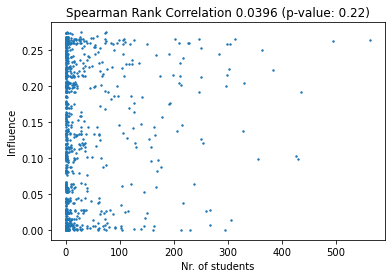

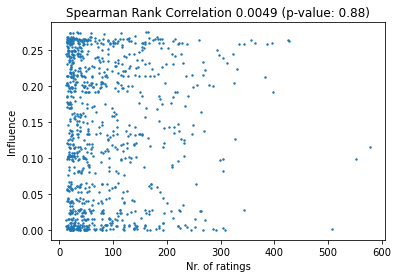

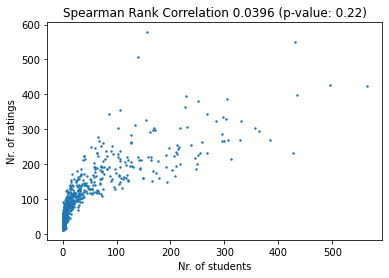

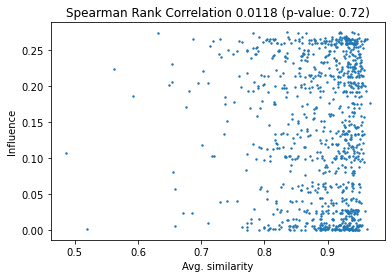

In [12]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [13]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.1836, All mentors: 0.1376
[Avg. Degree] Highest influential mentors: 19.2000, All mentors: 32.3839


In [14]:
np.mean(sorted(n_students, reverse=True)[:10])

411.7